AUTHOR: RUSLAN MASINJILA

EMAIL:  rmasinjila@mun.ca

COMP-6936-ASSIGNMENT-1

**Part 1 Motivation for the Topic:**

In this assignment I will explore the Interpretability of Generalized Additive Models (GAM) using LIME. [GAMs](https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_1197). Due to their additive nature, GAMS are [Interpretable](https://arxiv.org/pdf/2305.00537) are Machine Learning Models that extend Generalized Linear Models (GLMs) by allowing for more flexibility in capturing non-linear relationships between the input features and the target variable. link text, making them highly attactive for machine learning applications where Interpretability is paramount.

On the other hand, [LIME](https://dl.acm.org/doi/pdf/10.1145/2939672.2939778) stands for LOCAL INTERPRETABLE
MODEL-AGNOSTIC EXPLANATIONS. It is essentially a way to Interpret a Machine Learning Model Locally.

For this Assignment, I will use GAMs to predicture future Forex Prices, which are a form of Non-Stationary time series, evaluate the performance of GAMs in this type of applcation, and explore the Interpretability of the results using LIME.

In this part of the assignment. I will do the basic Steps to acquire and Prepare my data. So let us embark on this Journey.




**Step1. Acquisition of Data:** The first step was to get the prices. For this exercise, I chose EURUSD. These prices can be downloaded from within Windows Operating System using [Metatrader 5](https://www.metatrader5.com/en) and a [Python Library for Metatrader 5](https://pypi.org/project/MetaTrader5/) that goes with it. once everything was configured properly, I went ahead and downloaded rates for EURUSD for the last 10,000 hours as described [here](https://www.mql5.com/en/docs/python_metatrader5/mt5copyratesfrompos_py). The rates were then exported to .csv file, and the resulting file, EURUSD.csv was then uploaded to Google Colab for analysis.

**Step 2. Loading of Data:** Once uploaded to Google Colab, the next step was to load the data, and perhaps display it in a tabular form. As seen below, the price consists of a number of columns. Please note that I also have added some imports, variables, and steps that will be useful later. For example, you can already see how far into the future I plan to predict (5 hours ahead since the data is in hourly format). You can also tell that I will be using pygam for the GAM. Additionally, from the libraries you can see that I will use Kfold Cross Validation in py training and testing of GAM. The dataframe drops the last 5 rates because I plan to test GAM with unseen data.

In [42]:
#!pip install plotly                      # Uncoment this if running in Colab for the first time
#!pip install pygam                       # Uncoment this if running in Colab for the first time
#!pip install lime                        # Uncoment this if running in Colab for the first time

future_steps = 5  # Specify how many future steps you want to predict

import pandas as pd
import numpy as np
from pygam import LinearGAM, s
from sklearn.model_selection import KFold
from datetime import datetime
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt



# Load Data
rates_frame = pd.read_csv('EURUSD_RATES')[:-future_steps]
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
rates_frame.head(5)

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume,diff
0,0,2023-03-07 07:00:00,1.06903,1.06905,1.06810,1.06854,1293,0,0,-0.00049
1,1,2023-03-07 08:00:00,1.06853,1.06869,1.06761,1.06764,2050,0,0,-0.00089
2,2,2023-03-07 09:00:00,1.06763,1.06945,1.06747,1.06856,4805,0,0,0.00093
3,3,2023-03-07 10:00:00,1.06856,1.06863,1.06697,1.06736,5858,0,0,-0.00120
4,4,2023-03-07 11:00:00,1.06736,1.06736,1.06555,1.06568,6000,0,0,-0.00168


From the table of rates for EURUSD above, we can see some important columns, which will become our input and output features. Notable, the most important column, or the most frequently used colum is the close prices. However, traders use other prices such as open, high, low. Additionally, the time can play an important role, for example, during major economic or political news. Volume is aso important, but it must be real volume to make sense, because tick_volume is basically just saying the frequency of transactions within that hour.

**Step 3. Data Visualization:** bold text One of the first things we could do with raw tabular data like the rates for EURUSD in the table above. Visualization be involve plotting the values, displaying heatmaps, etc. For this example, I will display heatmaps using seaborn library

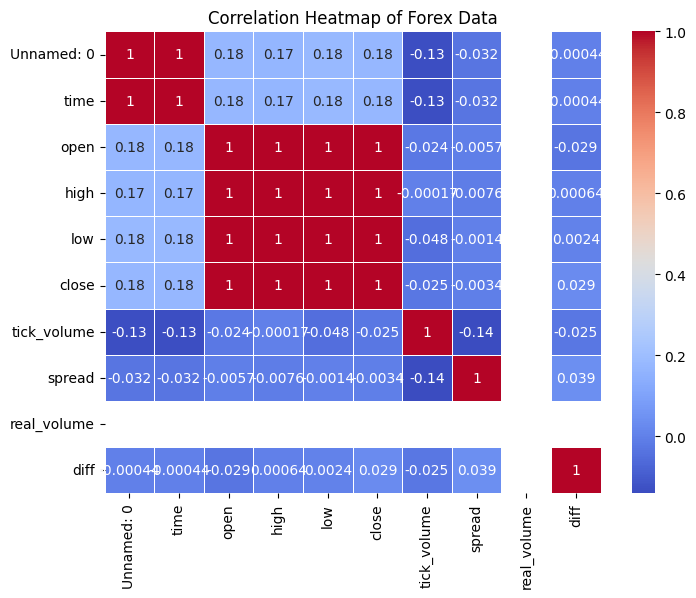

In [43]:
df = pd.DataFrame(rates_frame)

# Calculating the correlation matrix
corr_matrix = df.corr()

# Creating the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Showing the plot
plt.title("Correlation Heatmap of Forex Data")
plt.show()

As you can see from the heatmap above, it may not make sense at first, but one thing that is clearly visible is the high degree of correlation between open, high, low, and close values. These values basically represent the four levels of rates that a EURUSD achieves within a given time unit, in our case, 1 Hour. It is always a good idea to understand correlations between features so we can choose our features appropriatelly for our machine learning models

**Step. 4: Building a Machine Learning Model:** In this step, we start building our GAM. For reference, I had to consult [chatgpt](https://openai.com/index/chatgpt/) for assistance. Prior experience in using different types of Machine LEarning models was definetelly helpful, as the steps to generate a model from tabular data are usually similar. In this case, we are going to use close prices as out output, while open, high, low, tick_volume were used as input. The time had to be split into hours and minutes because it did not make sense to use the full form of datetime.

As usual, in the model belo, the X represents the input values, while the y represents the output values. Five-fold cross validation is used. Basically n-fold cross-validation repeats the training n times and averages the results. It is generally considered to be better in evaluating the performance of a trained model than simply deviding the data into 80 train and 20 test. I also recommend using fixed seed in any part tat involved randomization for reproducability. In my case, the seed for taking random samples in 5-fold cross-validation is called random_state and its value is 42.

GAM then fits the model additivelly by "final_gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)". This means GAM is applying a smoothing function to each of the input features and adds them together.

Once the model is ready, it can be used to make future prediction. As mentioned earlier, we want to predict up to 5 time units ahead, which is 5 hours ahead. Since GAM only uses the latest data row to predict just 1 step ahead, it becomes necessary for it to use its nth prediction in order to find its (n+1)th prediction. As you can see, this can quickly lead to the divergence of predicted values from the future values. Therefore, I recommend using as few steps ahead as possible when trying to predict time series with GAM

<ipython-input-44-a2a9c4c40a11>:47: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



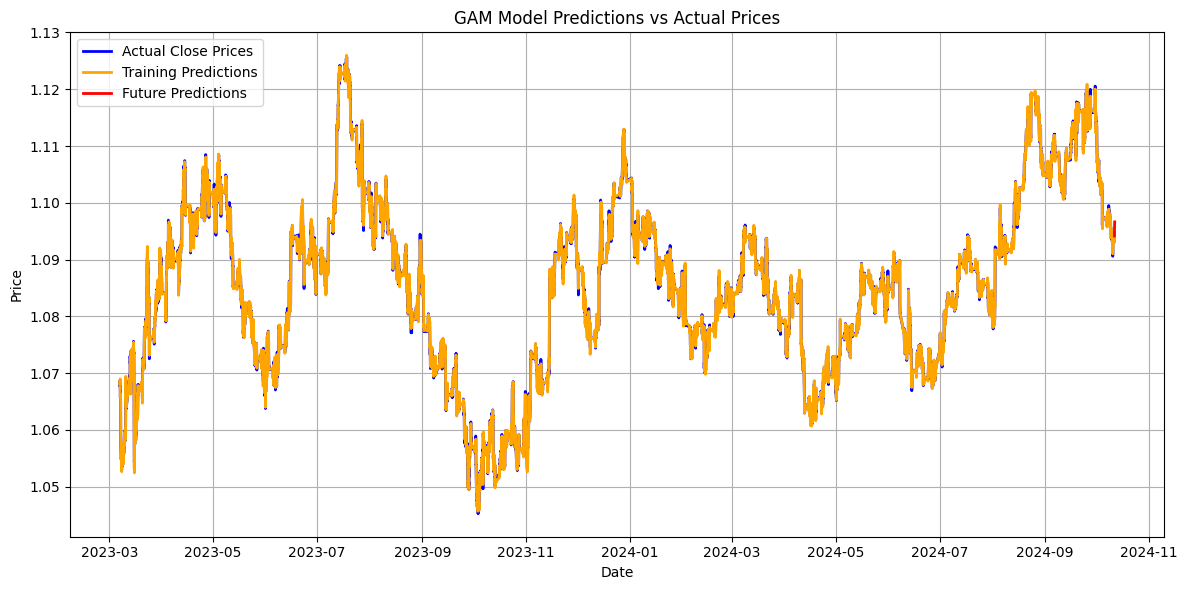

In [44]:
# Adding tick_volume - count the number of records (ticks) per time period
rates_frame['tick_volume'] = rates_frame.groupby('time')['time'].transform('count')

# Add hour_only and minute_only columns
rates_frame['hour_only'] = rates_frame['time'].dt.hour
rates_frame['minute_only'] = rates_frame['time'].dt.minute

# Prepare data for GAM
X = rates_frame[['open', 'high', 'low', 'tick_volume', 'hour_only', 'minute_only']]  # Include hour_only and minute_only
y = rates_frame['close']

# Fit GAM model with Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GAM model
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train, y_train)  # Include hour_only and minute_only in model

    # Predict using the GAM model
    predictions = gam.predict(X_test)

    # Calculate and store mean squared error for this fold
    mse = np.mean((predictions - y_test) ** 2)
    cross_val_scores.append(mse)



# Fit the final model on the entire dataset
final_gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)  # Include hour_only and minute_only in model

# Predict using the final model on the training data
train_predictions = final_gam.predict(X)

# Function to predict future prices
def predict_future_prices(model, last_data, future_steps):
    future_predictions = []
    for _ in range(future_steps):
        next_prediction = model.predict([last_data])
        future_predictions.append(next_prediction[0])

        # Update the last_data with the new prediction
        last_data = np.array([last_data[0], last_data[1], last_data[2], last_data[3], last_data[4], last_data[5]])  # Retain tick_volume, hour_only, minute_only
        last_data[2] = next_prediction  # Update low with predicted close (as an example)

    return future_predictions

# Predicting future prices
last_open = rates_frame['open'].iloc[-1]
last_high = rates_frame['high'].iloc[-1]
last_low = rates_frame['low'].iloc[-1]
last_tick_volume = rates_frame['tick_volume'].iloc[-1]  # Get last tick_volume
last_hour = rates_frame['hour_only'].iloc[-1]  # Get last hour
last_minute = rates_frame['minute_only'].iloc[-1]  # Get last minute
last_data = [last_open, last_high, last_low, last_tick_volume, last_hour, last_minute]

future_predictions = predict_future_prices(final_gam, last_data, future_steps)

# Create future dates for plotting
future_dates = pd.date_range(start=rates_frame['time'].iloc[-1], periods=future_steps + 1, freq='h')[1:]

# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'time': future_dates,
    'Predicted_Close': future_predictions
})

# Create a new figure
plt.figure(figsize=(12, 6))

# Actual Close Prices
plt.plot(rates_frame['time'], rates_frame['close'], label='Actual Close Prices', color='blue', linewidth=2)

# Training Predictions
plt.plot(rates_frame['time'], train_predictions, label='Training Predictions', color='orange', linewidth=2)

# Future Predictions
plt.plot(future_df['time'], future_df['Predicted_Close'], label='Future Predictions', color='red', linewidth=2)

# Update layout
plt.title('GAM Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

The plot above displays the predicted and actual values for the **training and testing data**. To my surprise, GAM's predicted prices follow the actual price very closely, much closer than other models I have used before.

**Step 5. Performance Evaluation** It is crucial that before proceeding any further, the performance of the model is evaluated. This can be done by comparing the actual values to predicted values. One of the most common metrics fo this comparison is the Mean Squared Error (MSE). In this case the MSE is about 1.2992937201974833e-07, which is good, however, this error is from the data tha was used in training and testing.

In [45]:
# Print the cross-validation results
print("#################################################################################")
print(f'Mean Squared Error from Cross-Validation: {np.mean(cross_val_scores)}')
print("#################################################################################")

#################################################################################
Mean Squared Error from Cross-Validation: 1.2992937201974833e-07
#################################################################################


**Step 6. Inference** This is the part where we used the training and evaluated model to infer, or actually predict the future. Had we used all the data for training and testing, we would not know how the model performs on future data until the future data before it arrived. This is why I left 5 last rows of data to simulate the prediction. Now let us check how the Mean Squared Error again. As seen from the print statement, it is around 4.000724741505345e-06, which is not a large deviation from the MSE of the train/test data.

In [46]:
predicted = list(future_df["Predicted_Close"].values)
actual = list(rates_frame["close"][-future_steps:].values)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse_future = mean_squared_error(actual, predicted)

print("#################################################################################")
print(f'Mean Squared Error Future Inference: {mse_future}')
print("#################################################################################")

#################################################################################
Mean Squared Error Future Inference: 4.000724741505345e-06
#################################################################################


**Step 7. Exploration of Interpretability of GAM** Up to this step, I haven't done anything new to a typical Machine Learning Pipeline. However, in this step, I am going to use LIME to figure out some details about the GAM model. Are there any features that are causing more harm to the model's performance than good? Are there any features that are not contributin to prediction? What are the most influential features in the positive or negative sense? This is where LIME comes in. LIME can shed light to feature importance. It does this by adding small variations, called perturbations, of the original data sample used to train and evaluate the model, in our case GAM. From these small variations, LIME learns an interpretable model that approximates the black box model within the area of the data sample. Because LIME is used to test for local interpretability, the following code checks for interpretability for 20 random samples. The random number is seeded to ensure reproducability of plots that follow.

These plots resulting from LIME are among the most valuable plots that help us understand what happens within GAM during price prediction. These plots are a bit customized from the default plots that the LIME library comes with to enhance visibility. By observing these plots, we see that the bars to the left of the 0 line in the horizontal axis are red, while the bars to the right are blue. The **RED** bars influence the prediction of future closing prices **NEGATIVELY** at the levels indicated on the vertical axis ( i.e at the chosen data sample). On the other hand, the **BLUE** bars influence the prediction **POSITIVELY** at at the same sample. The extent, or importance of their influence is shown in the horizontal axis. Since these plots come from only 20 random samples, they don't give us the whole picture. However, they provide good insights into what could be happening within the model.We can say that open, high and low prices have a great influence in the performance of the model. On the other hand, we can observe that the time, represented by hour_only and minute_only, and the tick_volume, have little to no influence on the model. The next Step is to ask ourselves, what else can we learn from our model? What would happen to the performance of GAM in the prediction of future prices if we remove the features that have little to no influence in the prediction. This will be investigated in **part2** of this assignment.

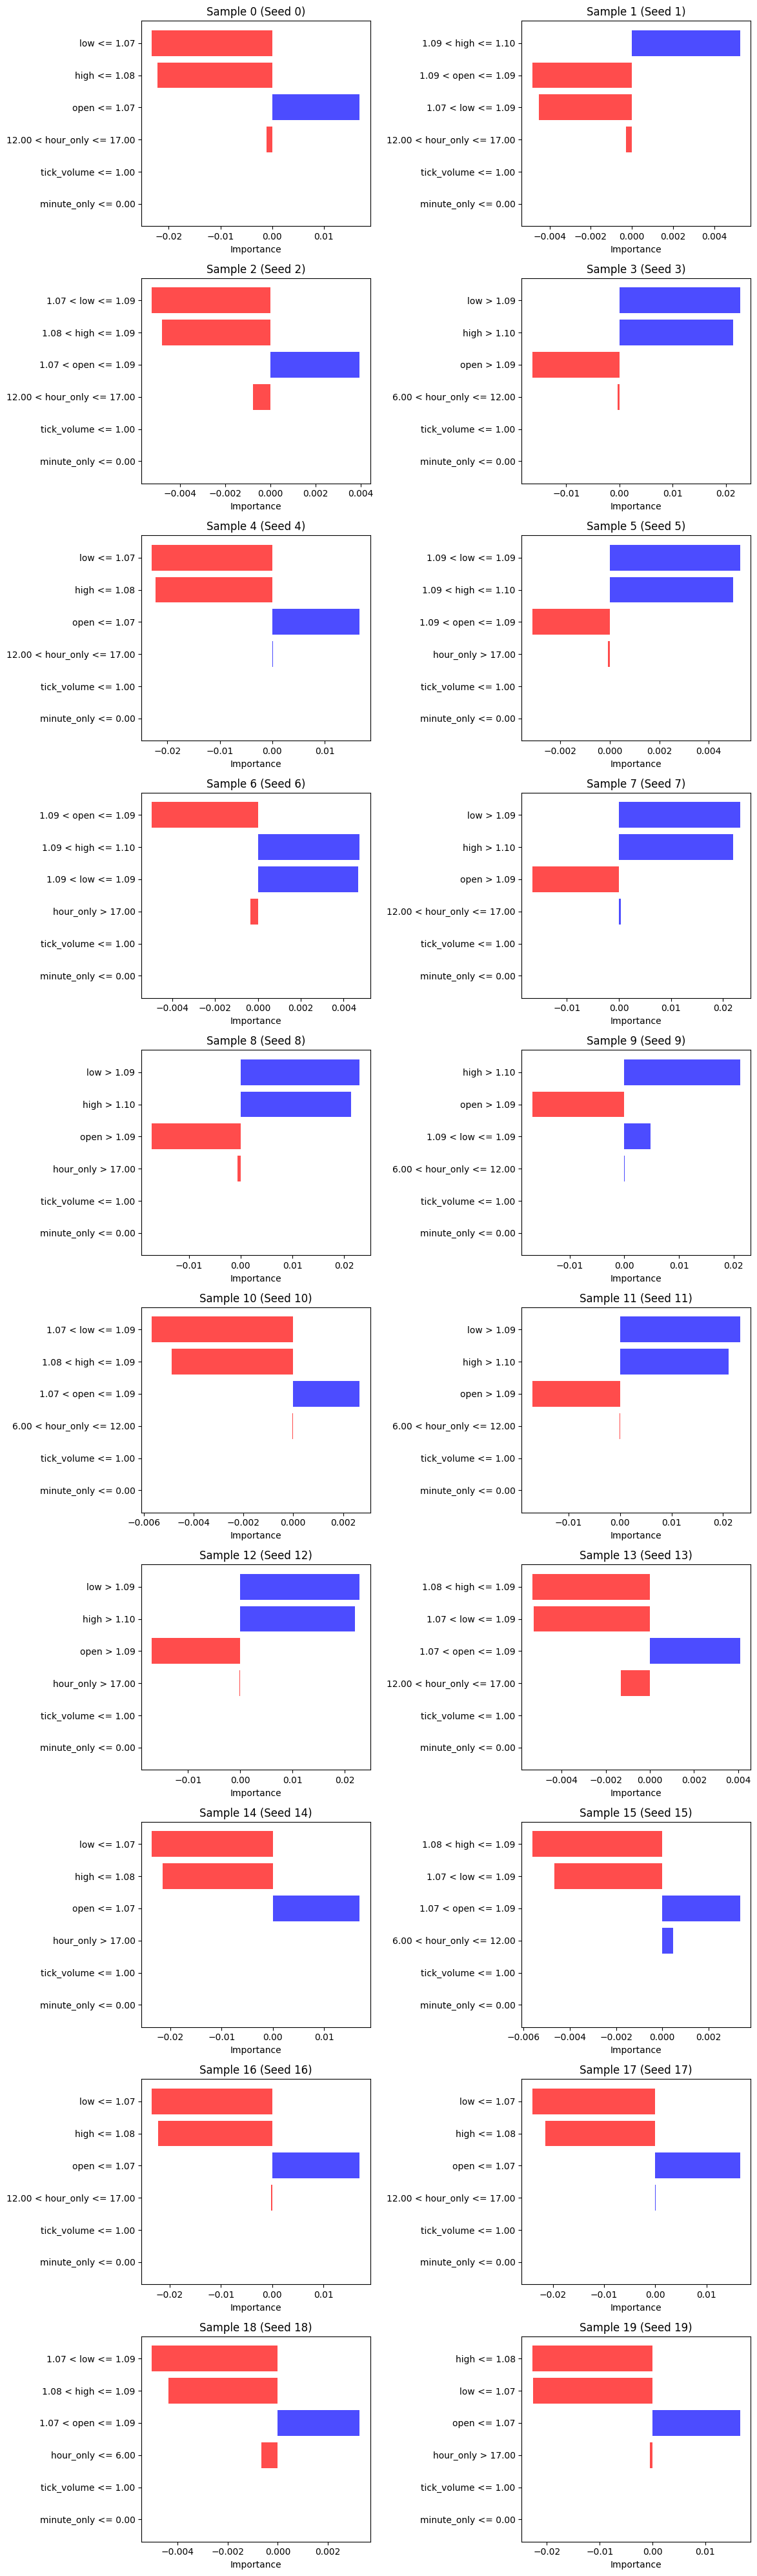

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Define the number of times to change the random seed
ntimes = 20

# Prepare a DataFrame to aggregate explanations
explanation_data = pd.DataFrame()

# Define the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X.values,  # Use the training data for explainer
    feature_names=X.columns,  # Feature names
    class_names=['Close Price'],  # Target variable name
    mode='regression'  # Regression problem
)

# Create a figure with subplots arranged in a grid (e.g., 2x5 for 10 plots)
fig, axs = plt.subplots(nrows=ntimes // 2, ncols=2, figsize=(12, 4 * (ntimes // 2)))  # Adjust layout to 2 columns
axs = axs.flatten()  # Flatten to easily loop through subplots

# Loop through the number of times to generate explanations
for i in range(ntimes):
    np.random.seed(i)  # Change the random seed
    sample_index = np.random.randint(0, len(X_test))  # Random sample from test set
    sample_data = X_test.iloc[sample_index].values  # Get the feature values of the sample

    # Generate explanation
    explanation = explainer.explain_instance(
        data_row=sample_data,
        predict_fn=final_gam.predict,  # Prediction function
        num_features=6  # Number of features to display
    )

    # Extract feature importances and feature names
    feature_importances = explanation.as_list()

    # Prepare data for plotting
    features, importances = zip(*feature_importances)

    # Convert to DataFrame for easy aggregation
    temp_df = pd.DataFrame({'feature': features, f'importance_seed_{i}': importances})
    explanation_data = pd.merge(explanation_data, temp_df, on='feature', how='outer') if not explanation_data.empty else temp_df

    # Plot the feature importances on the corresponding subplot
    colors = ['blue' if imp >= 0 else 'red' for imp in importances]  # Set color based on importance value
    axs[i].barh(features, importances, alpha=0.7, color=colors)
    axs[i].set_title(f'Sample {i} (Seed {i})')
    axs[i].set_xlabel('Importance')
    axs[i].invert_yaxis()  # Invert y-axis for better readability

# Adjust layout
plt.tight_layout()
plt.show()